In [1]:
import numpy as np
import pandas as pd

# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [2]:
df = pd.read_csv("../../data/interim/address_train_data.csv")
df.head()
df['label'].head()

0    False
1    False
2    False
3    False
4    False
Name: label, dtype: bool

In [3]:
df['label'] = df['label'].astype(int)

## Remove numbers from text

In [4]:
df['clean_address'] = df['address'].replace('\d+', '', regex=True)

## Balance dataset by force

In [5]:
t = df[df.label == True]
f = df[df.label == False]
small_f = f.iloc[np.random.randint(0, len(f), len(t)+1000)]
df_balanced = pd.concat([small_f, t])
df_balanced['label'].value_counts()

0    3000
1    2000
Name: label, dtype: int64

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(analyzer= 'char_wb', ngram_range=(3,3), use_idf=False)

In [7]:
X_raw = tfv.fit_transform(df_balanced['clean_address']).toarray()
y_raw = df_balanced['label'].to_numpy()
# X_raw.shape

In [8]:
# Isolate our examples for our labeled dataset.
BATCH_SIZE = 20

n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=BATCH_SIZE)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [9]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
# Specify our core estimator.
logreg = LogisticRegression()
sgd = SGDClassifier(loss='log')

In [10]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 3 samples at a time.
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=sgd, #logreg,

  X_training=X_train,
  y_training=y_train,

  query_strategy=preset_batch
)

In [11]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

In [12]:
unqueried_score

0.7328

In [36]:
def random_labels(y, fraction_of_random_labels=0.50, cardinality=3):
    mask = np.random.rand(*y.shape) < fraction_of_random_labels
    r = np.random.randint(0, 2, size = y.shape)
    y[mask] = r[mask]   
    return y

def fake_multi_user_labeling(y, n_labelers, only_zeroes_idx, fraction_of_random_labels=0.20, cardinality=3):
    y = np.tile(y, (n_labelers, 1)).transpose()
    y = random_labels(y, fraction_of_random_labels, cardinality)
    if only_zeroes_idx is not None:
        y[:,only_zeroes_idx] = 0
    return(y)

In [37]:
from snorkel.labeling import LabelModel, MajorityLabelVoter, RandomVoter

In [38]:
majority_voter = MajorityLabelVoter(cardinality=2)

In [13]:
# Pool-based sampling
#N_RAW_SAMPLES = 20
#N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE
N_QUERIES = 20

majority_voter = MajorityLabelVoter(cardinality=2)

performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    y = fake_multi_user_labeling(y, n_labelers = 3)
    
    y_vote = majority_voter.predict(y)
    learner.teach(X=X, y=y_vote)
    
    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.6756
Accuracy after query 2: 0.6522
Accuracy after query 3: 0.6316
Accuracy after query 4: 0.6210
Accuracy after query 5: 0.6082
Accuracy after query 6: 0.6124
Accuracy after query 7: 0.8276
Accuracy after query 8: 0.9584
Accuracy after query 9: 0.9864
Accuracy after query 10: 0.9848
Accuracy after query 11: 0.9924
Accuracy after query 12: 0.9874
Accuracy after query 13: 0.9918
Accuracy after query 14: 0.9940
Accuracy after query 15: 0.9932
Accuracy after query 16: 0.9924
Accuracy after query 17: 0.9934
Accuracy after query 18: 0.9944
Accuracy after query 19: 0.9946
Accuracy after query 20: 0.9962


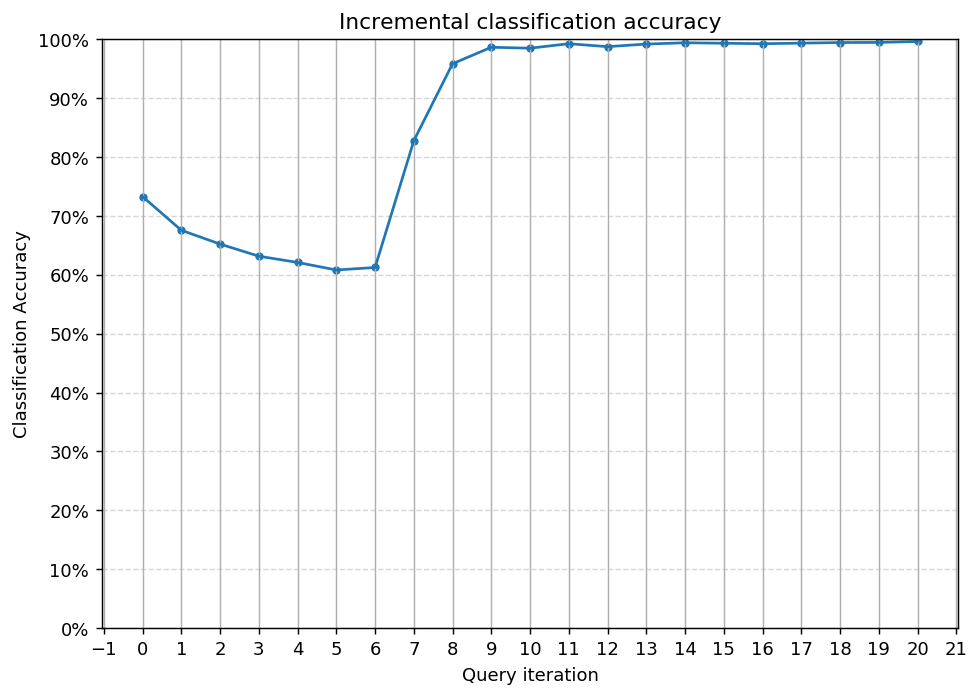

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

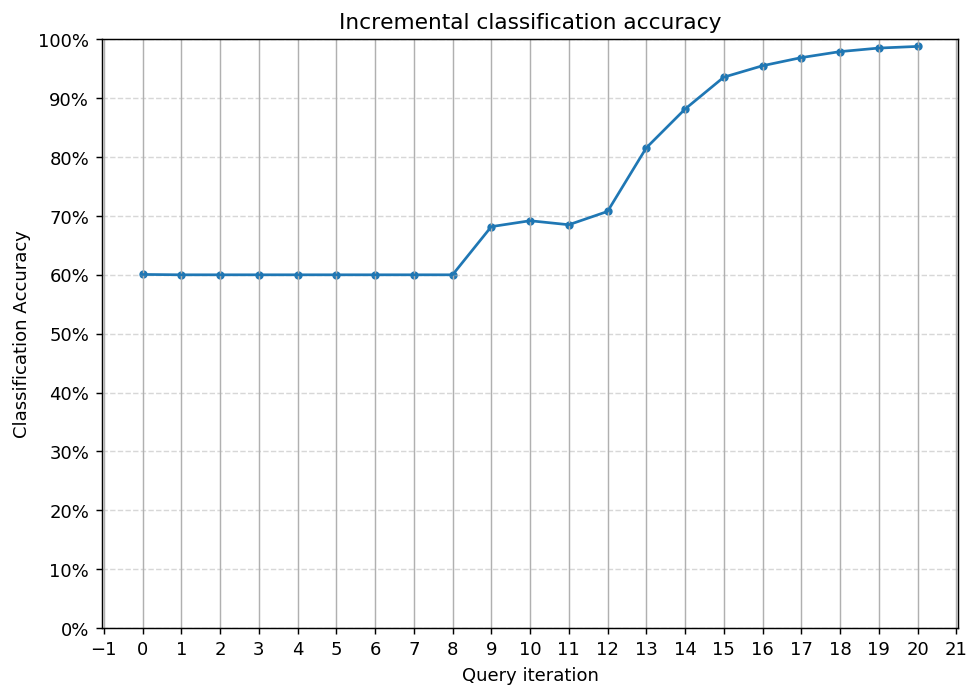

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()